#Steam Game Reviews with Sentiment Analysis

In [134]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import tensorflow as tf
import sklearn
import numpy as np
import re
import gensim
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Data Preprocessing

In [2]:
def preprocess(data):
    res = []
    lemmatizer = nltk.stem.WordNetLemmatizer() #Create the lemmatizer
    stopwords = nltk.corpus.stopwords.words('english') #Create the stopwords list

    for da in data:
        alphabets = re.sub("[^a-zA-Z]"," ", da[0]) #Replace non-alphabetic characters into blank space using regex
        words = nltk.word_tokenize(alphabets.lower()) #Tokenize the sentence and lowercase it
        stopped = [i for i in words if not i in stopwords] #Removing stopwords from the tokens
        lemmatized = [lemmatizer.lemmatize(i) for i in stopped] #Lemmatize the words

        res.append(lemmatized)
    return np.array(res)

In [3]:
dataframe = pd.read_csv('steam_reviews_edited.csv')

dataframe['review'] = dataframe['review'].str.lower()
dataframe['title'] = dataframe['title'].str.lower()

dataframe = dataframe.dropna()
dataframe = dataframe.reset_index()
dataframe = dataframe.drop(columns=['index', 'date_posted', 'funny', 'helpful', 'hour_played', 'is_early_access_review'])

dataframe

,recommendation,review,title
0,Recommended,&gt played as german reich&gt declare war on b...,expansion - hearts of iron iv: man the guns
1,Recommended,yes.,expansion - hearts of iron iv: man the guns
2,Recommended,very good game although a bit overpriced in my...,expansion - hearts of iron iv: man the guns
3,Recommended,out of all the reviews i wrote this one is pro...,dead by daylight
4,Recommended,disclaimer i survivor main. i play games for f...,dead by daylight
...,...,...,...
7457,Recommended,your flesh will rot and decay.steel is immorta...,"warhammer 40,000: mechanicus"
7458,Recommended,domini and dominae i believe what we are deali...,"warhammer 40,000: mechanicus"
7459,Recommended,first off if you like x com style of games you...,"warhammer 40,000: mechanicus"
7460,Recommended,as a disclaimer i'm an admech player on the ta...,"warhammer 40,000: mechanicus"


##Semantic Analyzer

###Preprocessing data for BPNN

In [4]:
total_rec = 0
total_notrec = 0
for x in dataframe['recommendation']:
    if x == 'Recommended':
        total_rec+= 1
    else:
        total_notrec+= 1
        
print(total_rec)
print(total_notrec)

5318
2144


In [5]:
#Data unbalanced, getting the maximum balanced amount of data possible.
rec = 0
notrec = 0
x_data = []
y_data = []
for index, row in dataframe.iterrows():
    if row['recommendation'] == 'Recommended':
        if rec == min(total_rec, total_notrec):
            continue
        rec+= 1
    else:
        if notrec == min(total_rec, total_notrec):
            continue
        notrec+= 1

    x_data.append(row['review'])
    y_data.append(row['recommendation'])

x_data = np.array(x_data)
y_data = np.array(y_data)

In [6]:
x_data

array(["&gt played as german reich&gt declare war on belgium&gt can't break belgium so go through france&gt capitulate france in order to get to belgium&gt get true blitzkrieg achievementthis game is dad",
       'yes.',
       "very good game although a bit overpriced in my opinion. i'd prefer playing the game with mods (historical accuracy so on) although the vanilla version is good aswell. 7/10",
       ...,
       'the game is fun but they removed all the glitches that made it "fun". if they don\'t put them back i\'m not changing my mind',
       'linux support was dropped with no warning i would not trust these developers to any promises. the game itself is quite fun with a friend although i can no longer play with my brother on windows. i also hit some game breaking bugs which required a game restart.',
       'amazingly fun game to play if you have a friend to play with you. main issue i have with the game is its lack of content. it only took us 5 hours to beat all the levels (i

In [7]:
x_data = x_data.reshape(-1, 1)
print(x_data.shape)
print(y_data.shape)

(4288, 1)
(4288,)


In [8]:
x_data = preprocess(x_data)

encoder = LabelEncoder()
y_data = encoder.fit_transform(y_data)

y_data = y_data.reshape(-1, 1)

print(x_data.shape)
print(y_data.shape)

(4288,)
(4288, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [9]:
x_data

array([list(['gt', 'played', 'german', 'reich', 'gt', 'declare', 'war', 'belgium', 'gt', 'break', 'belgium', 'go', 'france', 'gt', 'capitulate', 'france', 'order', 'get', 'belgium', 'gt', 'get', 'true', 'blitzkrieg', 'achievementthis', 'game', 'dad']),
       list(['yes']),
       list(['good', 'game', 'although', 'bit', 'overpriced', 'opinion', 'prefer', 'playing', 'game', 'mod', 'historical', 'accuracy', 'although', 'vanilla', 'version', 'good', 'aswell']),
       ...,
       list(['game', 'fun', 'removed', 'glitch', 'made', 'fun', 'put', 'back', 'changing', 'mind']),
       list(['linux', 'support', 'dropped', 'warning', 'would', 'trust', 'developer', 'promise', 'game', 'quite', 'fun', 'friend', 'although', 'longer', 'play', 'brother', 'window', 'also', 'hit', 'game', 'breaking', 'bug', 'required', 'game', 'restart']),
       list(['amazingly', 'fun', 'game', 'play', 'friend', 'play', 'main', 'issue', 'game', 'lack', 'content', 'took', 'u', 'hour', 'beat', 'level', 'including', 'hal

In [10]:
y_data

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [11]:
x_train_clean, x_test_clean, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

###Getting Word2Vec word embeddings matrix

In [12]:
#Word2Vec with CBOW algorithm
EMBEDDING_DIM = 200 #Vector size of the words' representation
word2vec = gensim.models.Word2Vec(x_train_clean, min_count=1, size=EMBEDDING_DIM, window=5)
vocab_size = len(word2vec.wv.vocab) #Counting the number of unique words
print(vocab_size)

12998


In [15]:
embedding_matrix = np.zeros((vocab_size+1, EMBEDDING_DIM)) #Matrix shape is (Number of unique words+1 x word embedding dimension) the +1 is for the empty word

for word, i in word_index.items():
    embedding_vector = word2vec.wv.word_vec(word) #Retrieve the word vector
    embedding_matrix[i] = embedding_vector #i-th Embedding matrix value = embedding for word represented by number i in the word index dictionary

In [16]:
embedding_matrix.shape

(12999, 200)

###Prepare data for BPNN

In [13]:
#Getting maximum length of tokens in one data.
maxlen = 0

for sent in x_train_clean:
    if maxlen < len(sent):
        maxlen = len(sent)

print(maxlen)

1778


In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False, split='') #Create the tokenizer
tokenizer.fit_on_texts(x_train_clean) #Fit the tokenizer on training data

x_train_clean = tokenizer.texts_to_sequences(x_train_clean) #Transform training data
x_test_clean = tokenizer.texts_to_sequences(x_test_clean) #Transform testing data
word_index = tokenizer.word_index #Save the word dictionary

In [17]:
#Pad missing data with zeroes
x_train_clean = tf.keras.preprocessing.sequence.pad_sequences(x_train_clean, maxlen=maxlen, padding='pre', truncating='pre')
x_test_clean = tf.keras.preprocessing.sequence.pad_sequences(x_test_clean, maxlen=maxlen, padding='pre', truncating='pre')

###Model Training and Evaluation

In [95]:
#Create the model
model = tf.keras.models.Sequential() 
model.add(tf.keras.layers.Embedding(input_dim=vocab_size+1, #Input dimension = Number of unique words+1
                                    output_dim=EMBEDDING_DIM, #Size of the word embeddings
                                    input_length=maxlen, #Length of the input
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), #Use the pre-trained Word2Vec word embeddings as constant value
                                    trainable=True)) #Define the weights as untrainable (constant value)

model.add(tf.keras.layers.BatchNormalization()) #Batch Normalization
model.add(tf.keras.layers.Flatten()) #Flatten the output from the layer before into 1 dimensional

model.add(tf.keras.layers.Dense(18, activation='relu')) #Fully-connected hidden layer
model.add(tf.keras.layers.BatchNormalization()) #Batch Normalization

model.add(tf.keras.layers.Dense(6, activation='relu')) #Fully-connected hidden layer
model.add(tf.keras.layers.BatchNormalization()) #Batch Normalization

model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #Fully-connected output layer

model.summary() #Print the model's summary

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1778, 200)         2599800   
_________________________________________________________________
batch_normalization_12 (Batc (None, 1778, 200)         800       
_________________________________________________________________
flatten_4 (Flatten)          (None, 355600)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 18)                6400818   
_________________________________________________________________
batch_normalization_13 (Batc (None, 18)                72        
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 114       
_________________________________________________________________
batch_normalization_14 (Batc (None, 6)                

In [96]:
#Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', #Adam Optimizer
              loss='binary_crossentropy', #Binary Crossentropy loss function
              metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) #Binary Accuracy, Precision, and Recall as the metrics

In [97]:
#Train the model
history = model.fit(x_train_clean, y_train, epochs=10, verbose=2, validation_split=0.1)

Epoch 1/10
97/97 - 7s - loss: 0.7008 - binary_accuracy: 0.5611 - precision_4: 0.5462 - recall_4: 0.6344 - val_loss: 0.7926 - val_binary_accuracy: 0.4665 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/10
97/97 - 5s - loss: 0.6693 - binary_accuracy: 0.5905 - precision_4: 0.5805 - recall_4: 0.6034 - val_loss: 0.9401 - val_binary_accuracy: 0.4665 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/10
97/97 - 5s - loss: 0.5218 - binary_accuracy: 0.7619 - precision_4: 0.7254 - recall_4: 0.8300 - val_loss: 0.7768 - val_binary_accuracy: 0.4694 - val_precision_4: 0.6667 - val_recall_4: 0.0109
Epoch 4/10
97/97 - 5s - loss: 0.3266 - binary_accuracy: 0.8847 - precision_4: 0.8471 - recall_4: 0.9341 - val_loss: 0.7093 - val_binary_accuracy: 0.4752 - val_precision_4: 0.6000 - val_recall_4: 0.0492
Epoch 5/10
97/97 - 5s - loss: 0.2168 - binary_accuracy: 0.9313 - precision_4: 0.9128 - recall_4: 0.9513 - val_loss: 0.6842 - val_binary_accuracy: 0.6093 - val_precision_4: 0.59

In [184]:
#Model's accuracy on testing data
model.evaluate(x_test_clean, y_test)

27/27 [==============================] - 0s 14ms/step - loss: 0.4701 - binary_accuracy: 0.7855 - precision_4: 0.8329 - recall_4: 0.7314


[0.4700580835342407,
 0.7855477929115295,
 0.8329048752784729,
 0.7313769459724426]

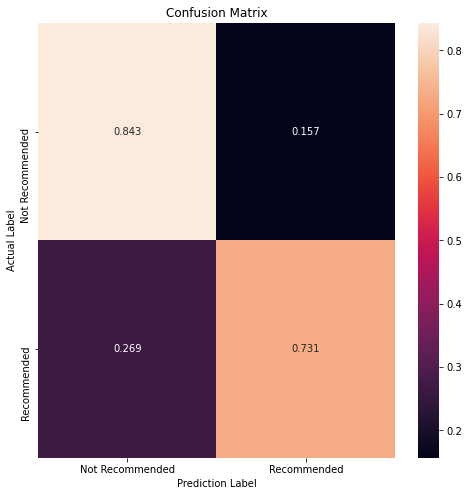

In [129]:
#Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (model.predict(x_test_clean) > 0.5).astype("int64")
test_labels = y_test

conf_matrix = confusion_matrix(test_labels, predictions, normalize='true')

class_names = encoder.classes_
plt.figure(figsize = (8,8))
graph = plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax=graph, fmt='.3g')

graph.set_title('Confusion Matrix')
graph.set_xlabel('Prediction Label')
graph.set_ylabel('Actual Label')
graph.xaxis.set_ticklabels(class_names)
graph.yaxis.set_ticklabels(class_names)
plt.show()

##TF-IDF Vectorizer

###Preprocessing data for TF-IDF Vectorizer

In [130]:
reviews = np.array(dataframe[['review']])
reviews.reshape(-1, 1)

array([["&gt played as german reich&gt declare war on belgium&gt can't break belgium so go through france&gt capitulate france in order to get to belgium&gt get true blitzkrieg achievementthis game is dad"],
       ['yes.'],
       ["very good game although a bit overpriced in my opinion. i'd prefer playing the game with mods (historical accuracy so on) although the vanilla version is good aswell. 7/10"],
       ...,
       ['first off if you like x com style of games you will most likely like this game. if you like warhammer 40k then this game will also appeal to you. this is one of the best warhammer 40k games i have ever played and the unit management upgrades combat is fantastic.one thing to note the campaign is relatively short and i beat it in 17 hours unlocking 17/22 achievements in my first play through. the game is relatively easy if you are used to x com style games even the hardest settings are easy and i was able to kill the final 3 bosses in just 3 rounds in the game with 

In [131]:
reviewPre = preprocess(reviews)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


###Create the Vectorizer model

In [135]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(smooth_idf=True, lowercase=False)

vectors = vectorizer.fit_transform([str(i) for i in reviewPre])

feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tfidf = pd.DataFrame(denselist, columns=feature_names)

##Testing with query words

In [181]:
def predict_query(query_word):
    #Transforming query word suitable for the Semantic Analyzer
    processed = preprocess(np.array([[query_word]])).tolist()
    processed = tokenizer.texts_to_sequences(processed)
    processed = tf.keras.preprocessing.sequence.pad_sequences(processed, maxlen=maxlen, padding='pre', truncating='pre')

    #Predict the query word's semantic
    prediction = (model.predict(processed) > 0.5).astype('int32')
    prediction = encoder.inverse_transform(prediction)

    return prediction

def get_review(query1, rank):
    query1 = query1.lower()
    #Transform the query into TF-IDF vector
    query1_vector = vectorizer.transform([query1])

    #Cosine similarity as TF-IDF metric
    query1_similarity_vector = sklearn.metrics.pairwise.cosine_similarity(vectors, query1_vector).reshape(-1)
    room = 0
    query1_tfidf_result = []

    for i in query1_similarity_vector:
        room += 1
        query1_tfidf_result.append([i, room])

    query1_tfidf_result.sort(reverse=True)
    prediction = predict_query(query1)
    
    print(f"Result: {prediction}\n")

    for i in range(rank):
        print("Score: " + str(query1_tfidf_result[i][0]))
        print("Game: " + dataframe['title'][query1_tfidf_result[i][1]-1])
        print("Review: ", end='')
        print(reviews[query1_tfidf_result[i][1]-1])
        print()

In [203]:
print('Search Bar: ', end='')
query1 = input()
#Getting top 5 query results
get_review(query1, 5)

Search Bar: i am addicted to this game
Result: ['Recommended']

Score: 0.92698328046499
Game: dead by daylight
Review: ['very good game addicted!']

Score: 0.5245009536675971
Game: subnautica
Review: ['the best survival game i have ever played. beware you will get addicted']

Score: 0.4294174610229347
Game: don't starve together
Review: ['this game along with the single player variant has kept me addicted for longer than any other game before it.i absolutely love it.']

Score: 0.39227797238253725
Game: slay the spire
Review: ['this is the perfect rogue like rng based card game ever ! just buy it you will definetly get addicted.']

Score: 0.37922922925539215
Game: rocket league®
Review: ["i'm addicted to this game. seriously i cannot recommend it enough. it requires skills yet even if you're a newbie (which is still my case) you can have a lot of fun!"]



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [204]:
print('Search Bar: ', end='')
query1 = input()
#Getting top 5 query results
get_review(query1, 5)

Search Bar: great, scary, horror game
Result: ['Recommended']

Score: 0.786400408309865
Game: dead by daylight
Review: ['great game but not very scary']

Score: 0.5823174762123728
Game: dead by daylight
Review: ['great survival horror game.']

Score: 0.4746095050393541
Game: dead by daylight
Review: ['very atmospheric great horror game!']

Score: 0.4280252653342213
Game: dead by daylight
Review: ['awesome game!can be pretty damn scary!']

Score: 0.4109773211925436
Game: subnautica
Review: ['love this game but its scary as hell lol']



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [205]:
print('Search Bar: ', end='')
query1 = input()
#Getting top 5 query results
get_review(query1, 5)

Search Bar: game is buggy, i want a refund
Result: ['Not Recommended']

Score: 0.5349176615182227
Game: playerunknown's battlegrounds
Review: ['fix your buggy game.']

Score: 0.4977895244877499
Game: rust
Review: ['2014 rust had a better community. i want that back. and i want a refund']

Score: 0.40721008959472976
Game: garry's mod
Review: ['after having played almost 1000 hours on this game i think i will refund it.10/10']

Score: 0.4070731599578599
Game: dead by daylight
Review: ['refund button is work']

Score: 0.39703931230006334
Game: playerunknown's battlegrounds
Review: ['this game is enjoyable when ur game is not buggy but unfortunately its very buggy and i cant evn open the game now']



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [206]:
print('Search Bar: ', end='')
query1 = input()
#Getting top 5 query results
get_review(query1, 5)

Search Bar: so many cheater and hacker
Result: ['Not Recommended']

Score: 0.6245795530826804
Game: playerunknown's battlegrounds
Review: ['there are too many cheaters']

Score: 0.6245795530826804
Game: playerunknown's battlegrounds
Review: ['why so many cheater?????']

Score: 0.5682628894409596
Game: rust
Review: ['too many hackers']

Score: 0.5230399699911117
Game: playerunknown's battlegrounds
Review: ['cheater']

Score: 0.45463075365035344
Game: playerunknown's battlegrounds
Review: ["don't buy this game! there are so many cheaters in this game right now and it's me off."]



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
